In [138]:
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample

In [139]:
# load dataset
df = pd.read_csv("/Users/samholt/GA/DSI12-lessons/projects/Capstone_Project/Capstone_MKII_DataFinal.csv'")

In [140]:
#set index to unnamed
df.drop("Unnamed: 0", axis= 1, inplace= True)

## Create Sparse Dataframe
* Data is far to large to convert into normal dataframe
* Requires creation of a sparse pivot, authors for rows, subreddits for columns & number of posts as variable

In [141]:
# creating unique list of subreddits with target as the last value for ease of data manipulation
unique_subs = list(df["subreddit"].unique())
unique_subs.remove("df_target")
unique_subs.append("df_target")

In [142]:
# data is to large for a pandas pivot table, creating a function to create a sparse version 

def create_sparse_pivot(rows, cols, data, values):
    ### function creates a sparse pivot table from large datasets
    r = CategoricalDtype(sorted(data[rows].unique()), ordered=True)
    c = CategoricalDtype(unique_subs)

    row = data[rows].astype(r).cat.codes
    col = data[cols].astype(c).cat.codes
    sparse_matrix = csr_matrix((df[values], (row, col)), \
                           shape=(r.categories.size, c.categories.size))
    
    return sparse_matrix

In [143]:
# create sparse df & column references
sparse_df = create_sparse_pivot("author", "subreddit", df, "posts")

In [144]:
# checking baseline prediction for full dataframe
baseline = pd.DataFrame(sparse_df[:, -1].todense())[0].value_counts(normalize= True)
baseline

0.0    0.94675
1.0    0.05325
Name: 0, dtype: float64

In [145]:
# create sample dataframe for proof of concept modelling
sample_df = resample(sparse_df, n_samples = 80000, random_state = 13)

# baseline of XX, high chance of overestimating the non-MH class- similar to the main sample
baseline = pd.DataFrame(sample_df[:, -1].todense())[0].value_counts(normalize= True)
baseline

0.0    0.946963
1.0    0.053038
Name: 0, dtype: float64

In [146]:
# creating target and predictor variables
X = sample_df[:,:-1]
y = sample_df[:,-1].toarray().ravel()

## Feature Selection 
* Given the sheer number of features, using a simple model-based selection process to reduce the number before looking into correlation and other factors

In [147]:
# going to take top 300 features through
num_feats = 500

In [148]:
# using random forest for feature selection
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
embeded_rf_selector.fit(X, y)



SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,

In [149]:
# get column references and create new X data
embeded_rf_support = embeded_rf_selector.get_support()

X_new = [X[:,i].todense() for i, j in enumerate(embeded_rf_support) if j == True]
X_cols = [unique_subs[i] for i, j in enumerate(embeded_rf_support) if j == True]

In [150]:
# create new database containing the relevant data
df_select = pd.DataFrame(np.concatenate(X_new, axis=1), columns= X_cols)

# append target variable
df_select["df_target"] = y


In [156]:
#final file to take through for processing
df_select.to_csv("/Users/samholt/GA/DSI12-lessons/projects/Capstone_Project/Capstone_MKII_DataProcessed.csv'")

## Understand correlation between the target and other subreddits

#### Understand correlation with target and top subreddits
* Given large number of subreddits, only looking at those which are the highest in terms of number of posts
* Overall correlation is low with the target variable for the majority of top subreddits, though some increase in correlation with subreddits centred around advice
* In the majority of instances correlation is very low (between -5 to 5% correlation with positive target)
    * Unsurprising given the significant imbalance within our target class and the fact that these are the most popular subreddits overall


In [153]:
# get correlation for all subreddits and target
df_corr = df_select.corr()[["df_target"]]

# get top 25 correlated
df_corr.sort_values(by= "df_target", ascending= False)[:25]

,df_target
df_target,1.000000
Advice,0.105098
AskDocs,0.096822
relationships,0.088487
socialskills,0.074322
raisedbynarcissists,0.070332
offmychest,0.069596
UnsentLetters,0.067035
confession,0.063294
lonely,0.063113


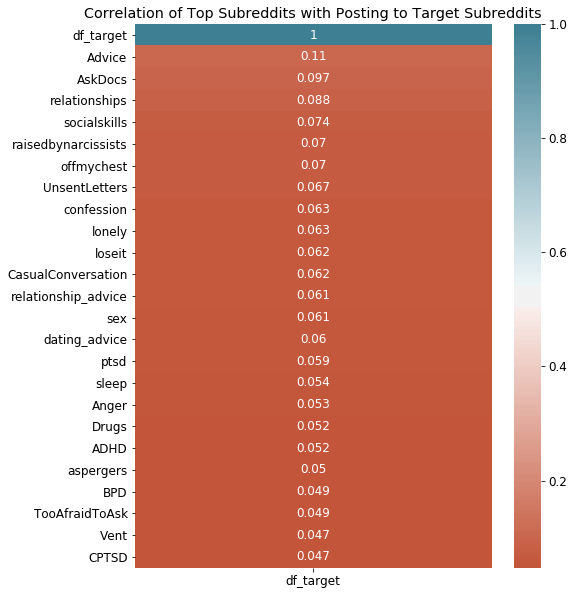

In [154]:
# get top 25 correlated
df_top_25_corr = df_corr.sort_values(by = "df_target", ascending= False)[:25]

f, ax = plt.subplots(figsize = (8, 10))
plt.rcParams.update({'font.size': 12})
sns.heatmap(df_top_25_corr,cmap=sns.diverging_palette(20, 220, n=200), xticklabels= True, yticklabels= True, annot = True).set_title("Correlation of Top Subreddits with Posting to Target Subreddits")
plt.show()

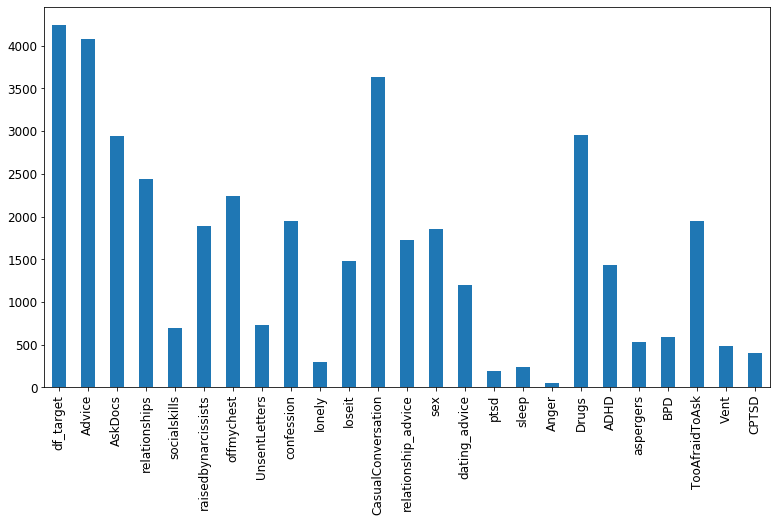

In [155]:
fig, ax = plt.subplots(figsize=(13, 7))
pd.DataFrame(df_select[df_top_25_corr.index].sum()).plot.bar(ax= ax, legend= False)

plt.show()